# ランダムポイントを作成

In [32]:
from geovoronoi import voronoi_regions_from_coords
from pyproj import CRS
from typing import List, Tuple
import geopandas as gpd
import numpy as np
import random
import shapely

In [6]:
n_points = 5000
epsg = 32630
aoi_sw = (281720, 991100)
aoi_ne = (309650, 1038020)

min_distance = 300

x_min, y_min = aoi_sw
x_max, y_max = aoi_ne

crs = CRS.from_user_input(epsg)

In [7]:
def check_min_distance(point:Tuple[float, float],
                       distance: float,
                       points:List[Tuple[float, float]]) -> bool:
    if distance == 0:
        return True
    neighbors = [_point for _point in points 
                 if ((point[0] - distance) < _point[0] < (point[0] + distance))
                 and ((point[1] - distance) < _point[1] < (point[1] + distance))]
    if len(neighbors) == 0:
        return True
    
    for neighbor in neighbors:
        if (neighbor[0] - point[0])**2 + (neighbor[1] - point[1])**2 < (distance * distance):
            return False
    return True

def random_points_in_extent(extent,
                            points_number,
                            min_distance = 0,
                            target_crs = None,
                            max_attempts=None,
                            **kwargs):
    max_attempts = points_number * 100
    if min_distance == 0:
        xs = [random.uniform(extent[0], extent[1]) for i in range(points_number)]
        ys = [random.uniform(extent[2], extent[3]) for i in range(points_number)]
        coords = list(zip(xs, ys))
    else:
        n_iterations = 0
        coords: List[Tuple[float, float]] = []
        while (len(coords) < points_number
               and n_iterations < max_attempts):
            x = random.uniform(extent[0], extent[1])
            y = random.uniform(extent[2], extent[3])
            if check_min_distance(point = (x, y),
                                  distance= min_distance,
                                  points=coords):
                coords.append((x, y))
            n_iterations += 1
    if len(coords) < points_number:
        raise ValueError('Could not generate requested number of random '
                         'points. Maximum number of attempts exceeded.')
    points = [shapely.geometry.Point(xy) for xy in coords]
    return points

points = random_points_in_extent(extent=(x_min, x_max, y_min, y_max),
                              points_number=n_points,
                              min_distance=min_distance)

                            geometry
0     POINT (287893.392 1018214.643)
1     POINT (285148.864 1014868.117)
2     POINT (287899.065 1025273.749)
3     POINT (285436.212 1024048.643)
4     POINT (305583.354 1030906.243)
...                              ...
4995   POINT (295744.972 991109.631)
4996  POINT (288134.856 1008041.496)
4997  POINT (295590.617 1032175.490)
4998  POINT (296341.666 1015281.349)
4999  POINT (294665.756 1026773.806)

[5000 rows x 1 columns]
epsg:32630


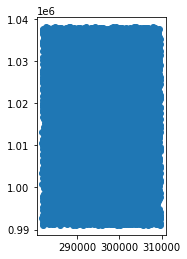

In [8]:
points_gdf = gpd.GeoDataFrame(geometry=points, crs=crs)
points_gdf.plot()
print(points_gdf)
print(points_gdf.crs)

In [11]:
buf_gdf = points_gdf.buffer(distance=100)
buf_gdf.to_file('data/random_point_buffer.shp')

In [19]:
w, s, e, n = tuple(buf_gdf.total_bounds)


In [24]:
bbox_gdf = gpd.GeoDataFrame(geometry=[shapely.geometry.Polygon([[w,s], [e,s], [e, n], [w, n]])],
            crs=crs)
bbox_gdf

,geometry
0,"POLYGON ((281623.778 991009.060, 309742.385 99..."


In [48]:
coords = np.array(list(zip(points_gdf.geometry.x,
             points_gdf.geometry.y)))
coords

array([[ 287893.39199138, 1018214.64345841],
       [ 285148.86447053, 1014868.11724793],
       [ 287899.06484794, 1025273.74931047],
       ...,
       [ 295590.6170732 , 1032175.48955649],
       [ 296341.66619983, 1015281.34936073],
       [ 294665.75636229, 1026773.80561081]])

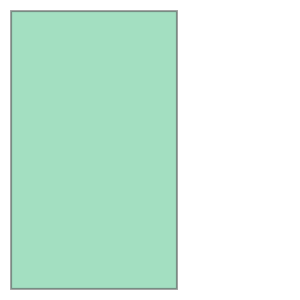

In [39]:
area_shape = bbox_gdf.geometry[0]
area_shape

In [49]:
poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(coords, area_shape)


In [51]:
gpd.GeoDataFrame(geometry=poly_shapes, crs=crs).buffer(distance=-30).to_file('data/voronoi.shp')

In [46]:
poly_to_pt_assignments

[[5], [4], [7], [2], [6], [0], [9], [1], [3], [8]]